In [2]:
%matplotlib inline
from memory_profiler import memory_usage
import os
import pandas as pd
from glob import glob
import numpy as np


In [ ]:
%%capture
!apt-get install libav-tools -y

In [3]:
from keras import layers
from keras import models
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import keras.backend as K
from scipy.io import wavfile
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc
from scipy.fftpack import fft
from path import Path

import IPython.display as ipyd

Using TensorFlow backend.


### Extracting all train_curated .wav files from zip folder

In [4]:
import zipfile
# Will unzip the files so that you can see them..
with zipfile.ZipFile("../input/freesound-audio-tagging-2019/train_curated.zip","r") as z:
    z.extractall("train/.wav")

# 1. Understanding Spectrogram

> ## Let's first load two .wav files samples and vizualize the raw wave

In [5]:
#https://www.kaggle.com/davids1992/audio-representation-what-it-s-all-about

train_audio_path = './train/.wav' 

sample_rate1, samples1 = wavfile.read(os.path.join(train_audio_path, '98b0df76.wav'))
sample_rate2, samples2 = wavfile.read(os.path.join(train_audio_path, 'd7d25898.wav'))

## 1.1 Following is the audio clip of the two sample audio 

In [6]:
# Following noise labled as "BUS"

ipyd.Audio(samples1, rate=sample_rate1)

In [7]:
# Following noise labled as "Traffic_noise_and_roadway_noise"


ipyd.Audio(samples2, rate=sample_rate2)

## 1.2 Ploting the sound wave plot of .wav files

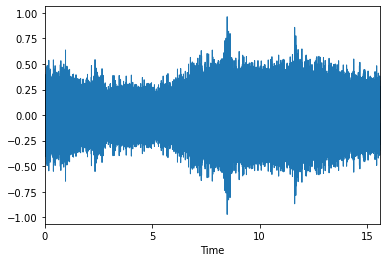

In [8]:
filename1 = './train/.wav/98b0df76.wav'
y_1, sr1 = librosa.load(filename1,sr=None,mono=True,offset=0.0,duration=None)
# trim silent edges
yt1, _ = librosa.effects.trim(y_1)
librosa.display.waveplot(yt1, sr=sr1)

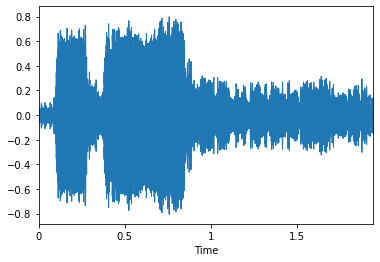

In [9]:
filename2 = './train/.wav/d7d25898.wav'
y_2, sr2 = librosa.load(filename2,sr=None,mono=True,offset=0.0,duration=None)
# trim silent edges
yt2, _ = librosa.effects.trim(y_2)
librosa.display.waveplot(yt2, sr=sr2)

### The problem with the raw Wave is we could not interpret and understand the pitch just by seeing the physical form.By seeing the image we can say second wave is more loud as it has higher values of amplitude.

# **1.3. FFT**
###  Now we are converting the signals from time domain to Frequency domain by implemention of fast Fourier transform (FFT)    

## Fourier Transform is a mathematical concept that can convert a continuous signal from time-domain to frequency-domain. 
## Fourier Transform decompose a signal into its constituent frequencies.

## **Simple Sine Wave to Understand FFT**

## The following example is taken from [this](https://towardsdatascience.com/understanding-audio-data-fourier-transform-fft-spectrogram-and-speech-recognition-a4072d228520) blog, to understand FFT clearly.

###  The following piece of code creates a sine wave with a sampling rate = 100, amplitude = 1 and frequency = 3. Amplitude values are calculated every 1/100th second (sampling rate) and stored into a list called y1. 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


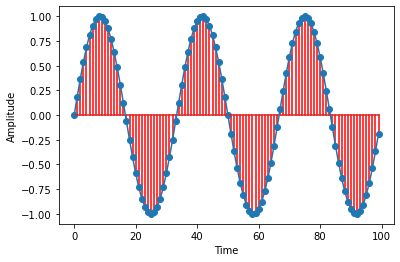

In [10]:
samples=100
f=3
x=np.arange(samples)
y1=np.sin(2*np.pi*f*(x/samples))
plt.figure()
plt.stem(x,y1,'r',)
plt.plot(x,y1)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

## Now we plot FFT for above Sin wave using scipy fft

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  """


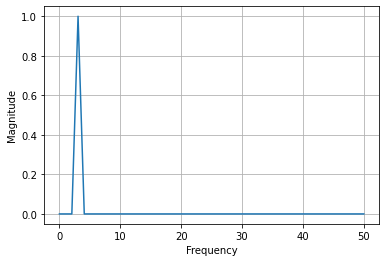

In [11]:
import scipy
def fft_plot(audio,sampling_rate):
    n=len(audio)
    T=1/sampling_rate
    yf= scipy.fft(audio)
    #xf=np.linspace(0.0,1.0/(2.0*T),n//2.0)
    xf = np.linspace(0.0, 1.0/(2.0*T), n//2)
    fig,ax=plt.subplots()
    #plt.figure(figsize=(14, 3))
    ax.plot(xf,2.0/n*np.abs(yf[:n//2]))
    plt.grid()
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    return plt.show()

yf=fft_plot(y1,100)

### So in above plot we convert our wave from time domain to frequency domain via FFT 


### Let's Plot another Sin wave

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


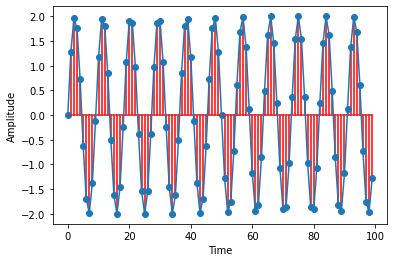

In [12]:
samples=100
f=11
x=np.arange(samples)
y2=2*np.sin(2*np.pi*f*(x/samples))
plt.figure()
plt.stem(x,y2,'r',)
plt.plot(x,y2)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  """


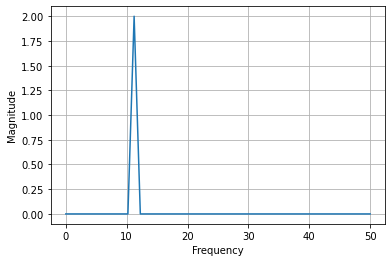

In [13]:
yf2=fft_plot(y2,100)

### Now we are merging both y1 and y2

In [14]:
y3= y1 + y2

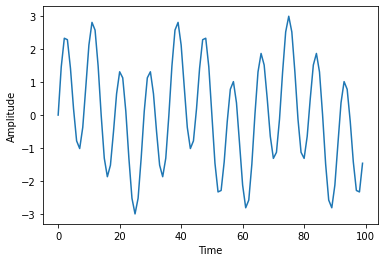

In [15]:
samples=100
#f=11
x=np.arange(samples)
#y3=np.sin(2*np.pi*f*(x/samples))
plt.figure()
#plt.stem(x,y3,'r',)
plt.plot(x,y3)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  """


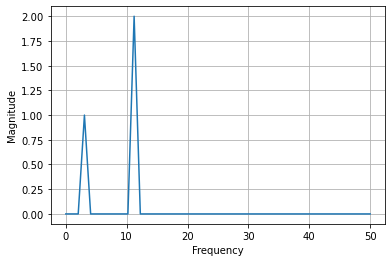

In [16]:
yf3=fft_plot(y3,100)

## In above plot we can see using Frequency domain plot we can easily find 2 different sin wave 

## Let's plot FFT for the selected .wav files 

## **FFT on our Audio signal**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  """


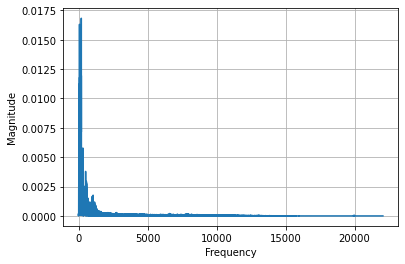

In [17]:
fft_plot(y_1, sr1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  """


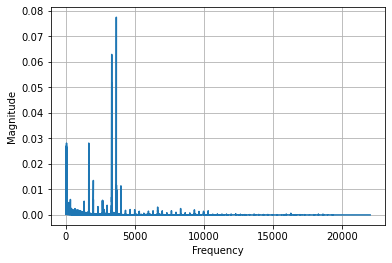

In [18]:
fft_plot(y_2, sr2)

### Now we are getting Frequencies information but time information is missing. 

# **1.4. Why Spectrogram ?**



### If we consider only frequency we cannot get the actual sequence of the frequency, for example in speech recognition system suppose sentance is **"Hi Alexa its Raj"**,using frequency we might get the words but without time information sequence of words is missing.

### We need to find a different way to calculate features for our system such that it has frequency values along with the time at which they were observed. Here Spectrograms come into the picture.

### So the plot of frequencies along with time for signal is called Spectrogram.



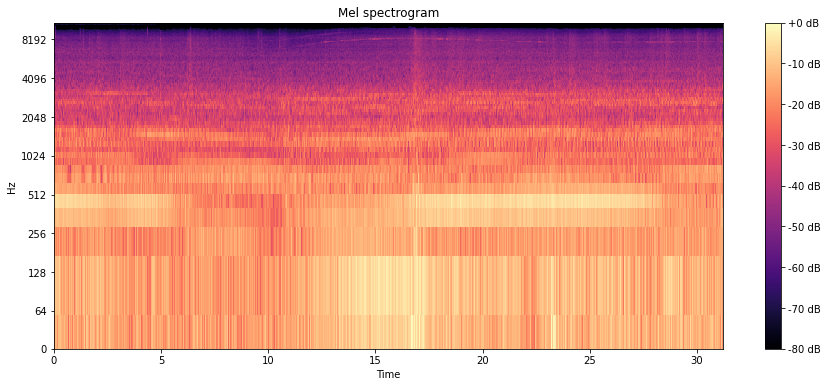

In [19]:
clip, sample_rate = librosa.load(filename1, sr=None)
plt.figure(figsize=(15, 6))
S = librosa.feature.melspectrogram(y=clip, sr=44100,n_mels=96)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),x_axis='time',y_axis='log',fmin=20,fmax=20000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.show()

### X-axis represents Time,Y-axis represents Frequency,color code represents loudness in DB, above plot is log plot of Spectrogram    

### The main Idea of Spectrogram is we divide wave in small windows and calculate FFT for each window, window number represents time (window 1, window 2, ...), and its better to have overlapped window as without overlapping we may lose some frequencies.

# **2. Agumentation**

## 2.1. Adding simple agumentation to audio waves

In [20]:
#https://www.youtube.com/watch?v=m0-JHQeLf3k

# This below code is refered from above youtube video, here we are shifting the audio little bit using np.roll, and adding some ramdom small noises.


def simple_augument_audio(audio, shift_portion = 0.05, volume_change = 0.1, noise =0.01):
    
    # shifting the audio wave little bit using np.roll
    shift = round(shift_portion*audio.shape[0])
    audio=np.roll(audio, np.random.randint(-shift,shift))
    
    # volume
    audio*= (np.random.random()*2-1) * volume_change * 1
    
    #noise
    audio +=np.random.normal(0,audio.max()*noise,audio.shape)
    
    return audio

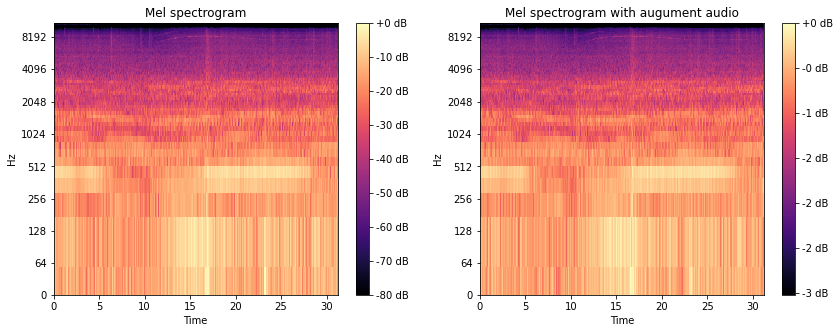

In [21]:

# For .wav file 1
clip, sample_rate = librosa.load(filename1, sr=None)

S = librosa.feature.melspectrogram(y=clip, sr=44100,n_mels=96)
x=librosa.power_to_db(S, ref=np.max)

fig = plt.figure(figsize=(14,5))
plt.subplot(121)

librosa.display.specshow(x,x_axis='time',y_axis='log',fmin=20,fmax=20000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')


plt.subplot(122)
librosa.display.specshow(simple_augument_audio(x),x_axis='time',y_axis='log',fmin=20,fmax=20000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram with augument audio')
 

plt.show()   

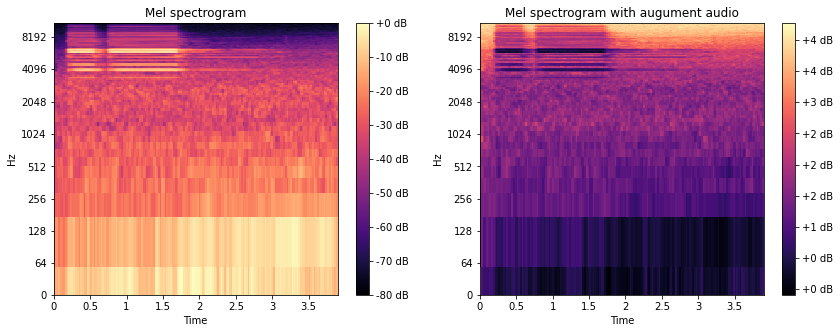

In [22]:
# For .wav file 2

clip, sample_rate = librosa.load(filename2, sr=None)

S = librosa.feature.melspectrogram(y=clip, sr=44100,n_mels=96)
x=librosa.power_to_db(S, ref=np.max)

fig = plt.figure(figsize=(14,5))
plt.subplot(121)

librosa.display.specshow(x,x_axis='time',y_axis='log',fmin=20,fmax=20000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')


plt.subplot(122)
librosa.display.specshow(simple_augument_audio(x),x_axis='time',y_axis='log',fmin=20,fmax=20000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram with augument audio')
 

plt.show()   

## 2.2 Spectrogram Agumentation using  time and frequency masking

### We are implementing frequency and time masking in below function. In masking we select some random rows and columns based on default maximum masking percentages and replace the values by zero. Following lines are taken from paper to implement masking. 

<p>Frequency masking (FM): f consecutive Mel-frequency channels [f0, f0 + f) is selected, where f is a discrete random variable ∈ [0, F], 
F is the frequency masking parameter, f0 is chosen from [0, ν−f]. Selected region is replaced by the minimum
value. This process is repeated Nf times.
                                                              
                                                              
Time masking (TM): t consecutive time steps [t0, t0 + t) is
selected, where t is a discrete random variable ∈ [0, T], T is the
time masking parameter, t0 is chosen from [0, τ − t]. Selected
region is replaced by the minimum value. This process is repeated Nt times.</p>

In [23]:
#https://www.kaggle.com/davids1992/specaugment-quick-implementation
#https://arxiv.org/pdf/2001.01401.pdf

def timeFreqMasking(X: np.ndarray, num_mask=2, 
                 freq_masking_max_percentage=0.15, time_masking_max_percentage=0.3):

    X = X.copy()
    all_frames_num, all_freqs_num = X.shape
    time_num,freq_num = X.shape
    for i in range(num_mask):
        
        #### Frequency Masking ####
        freq_percentage = np.random.uniform(0.0, freq_masking_max_percentage)
        
        num_freqs_to_mask = int(freq_percentage * freq_num)
        f0 = int(np.random.uniform(low=0.0, high=freq_num - num_freqs_to_mask))
        #f0 = int(f0)
        X[:, f0:f0 + num_freqs_to_mask] = 0
        
        #### Time Masking ####
        time_percentage = np.random.uniform(0.0, time_masking_max_percentage)
        
        num_frames_to_mask = int(time_percentage * time_num)
        t0 = int(np.random.uniform(low=0.0, high=time_num - num_frames_to_mask))
        #t0 = int(t0)
        X[t0:t0 + num_frames_to_mask, :] =0
    
    return X
    

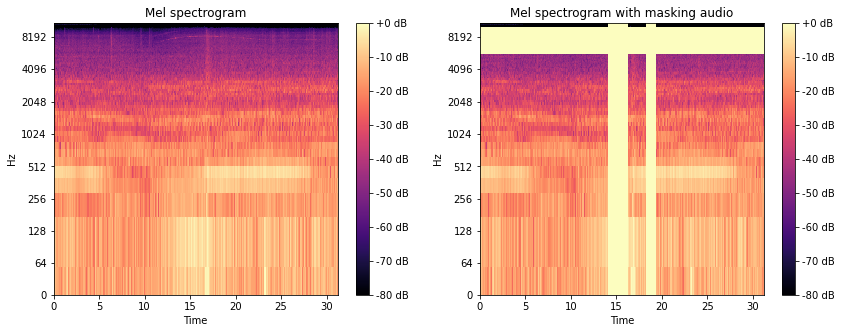

In [24]:
# For .wav file 1

clip, sample_rate = librosa.load(filename1, sr=None)

S = librosa.feature.melspectrogram(y=clip, sr=44100,n_mels=96)
x=librosa.power_to_db(S, ref=np.max)

fig = plt.figure(figsize=(14,5))
plt.subplot(121)

librosa.display.specshow(x,x_axis='time',y_axis='log',fmin=20,fmax=20000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')


plt.subplot(122)
librosa.display.specshow(timeFreqMasking(x),x_axis='time',y_axis='log',fmin=20,fmax=20000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram with masking audio')
 

plt.show()   

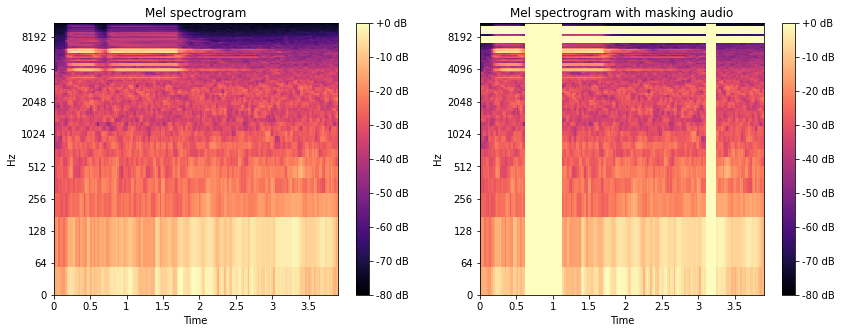

In [25]:
# For .wav file 2

clip, sample_rate = librosa.load(filename2, sr=None)

S = librosa.feature.melspectrogram(y=clip, sr=44100,n_mels=96)
x=librosa.power_to_db(S, ref=np.max)

fig = plt.figure(figsize=(14,5))
plt.subplot(121)

librosa.display.specshow(x,x_axis='time',y_axis='log',fmin=20,fmax=20000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')


plt.subplot(122)
librosa.display.specshow(timeFreqMasking(x),x_axis='time',y_axis='log',fmin=20,fmax=20000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram with masking audio')
 

plt.show()   


# **3. Dataset**

## We have 2 training files: 

* Train_curated (Its manually labled data)
* Train_noisy (Its labled by a pretrained model, contains noise)


In [4]:
train_curated=pd.read_csv("../input/freesound-audio-tagging-2019/train_curated.csv")
train_curated.head()

## This problem is multilable classification which means one .wav file may have more than 1 classes so we are now using MultiLabelBinarizer lib to one hot encode is and extract number of classes we have.

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb1 = MultiLabelBinarizer()
labels_train_curated=mlb1.fit_transform([ i.split(",") for i in list(train_curated["labels"])])

In [28]:
print("Train curated has {} rows".format(train_curated.shape[0]))
print("Train curated has {} Classes".format(labels_train_curated.shape[1]))
print("Train curated labels average sample rate of {}".format(np.average(np.sum(labels_train_curated, axis=0))))

Train curated has 4970 rows
Train curated has 80 Classes
Train curated labels average sample rate of 71.9


## Ploting the sample sizes of lables in Train curated data

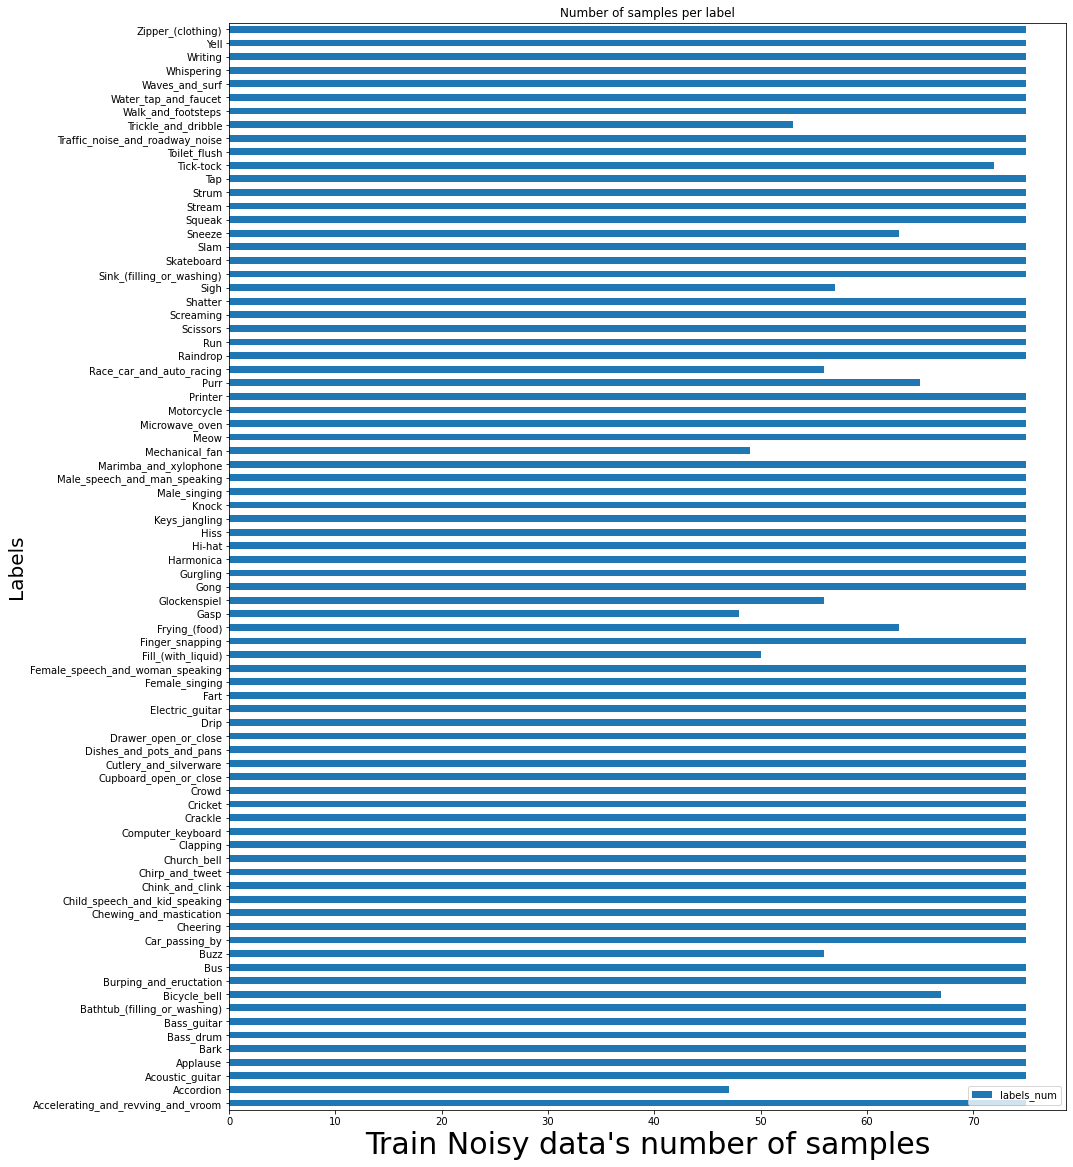

In [29]:
#https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data


curated_plot_df = pd.DataFrame({"labels_num":list(np.sum(labels_train_curated, axis=0)),"labels":list(mlb1.classes_)})
curated_plot_df.set_index('labels',inplace=True)
plot = curated_plot_df.plot(
    kind='barh',
    title="Number of samples per label",
    figsize=(15,20))
plot.set_xlabel("Train Noisy data's number of samples", fontsize=30)
plot.set_ylabel("Labels", fontsize=20);


In [30]:
train_noisy=pd.read_csv("../input/freesound-audio-tagging-2019/train_noisy.csv")
train_noisy.head()

,fname,labels
0,00097e21.wav,Bathtub_(filling_or_washing)
1,000b6cfb.wav,Motorcycle
2,00116cd2.wav,"Marimba_and_xylophone,Glockenspiel"
3,00127d14.wav,"Water_tap_and_faucet,Sink_(filling_or_washing)"
4,0019adae.wav,Raindrop


In [31]:
mlb2 = MultiLabelBinarizer()
labels_train_noisy=mlb2.fit_transform([ i.split(",") for i in list(train_noisy["labels"])])

In [32]:
print("Train Noisy has {} rows".format(train_noisy.shape[0]))
print("Train curated has {} Classes".format(labels_train_noisy.shape[1]))
print("Train curated labels average sample rate of {}".format(np.average(np.sum(labels_train_noisy, axis=0))))

Train Noisy has 19815 rows
Train curated has 80 Classes
Train curated labels average sample rate of 300.0


## Ploting the sample sizes of lables in Train Noisy data

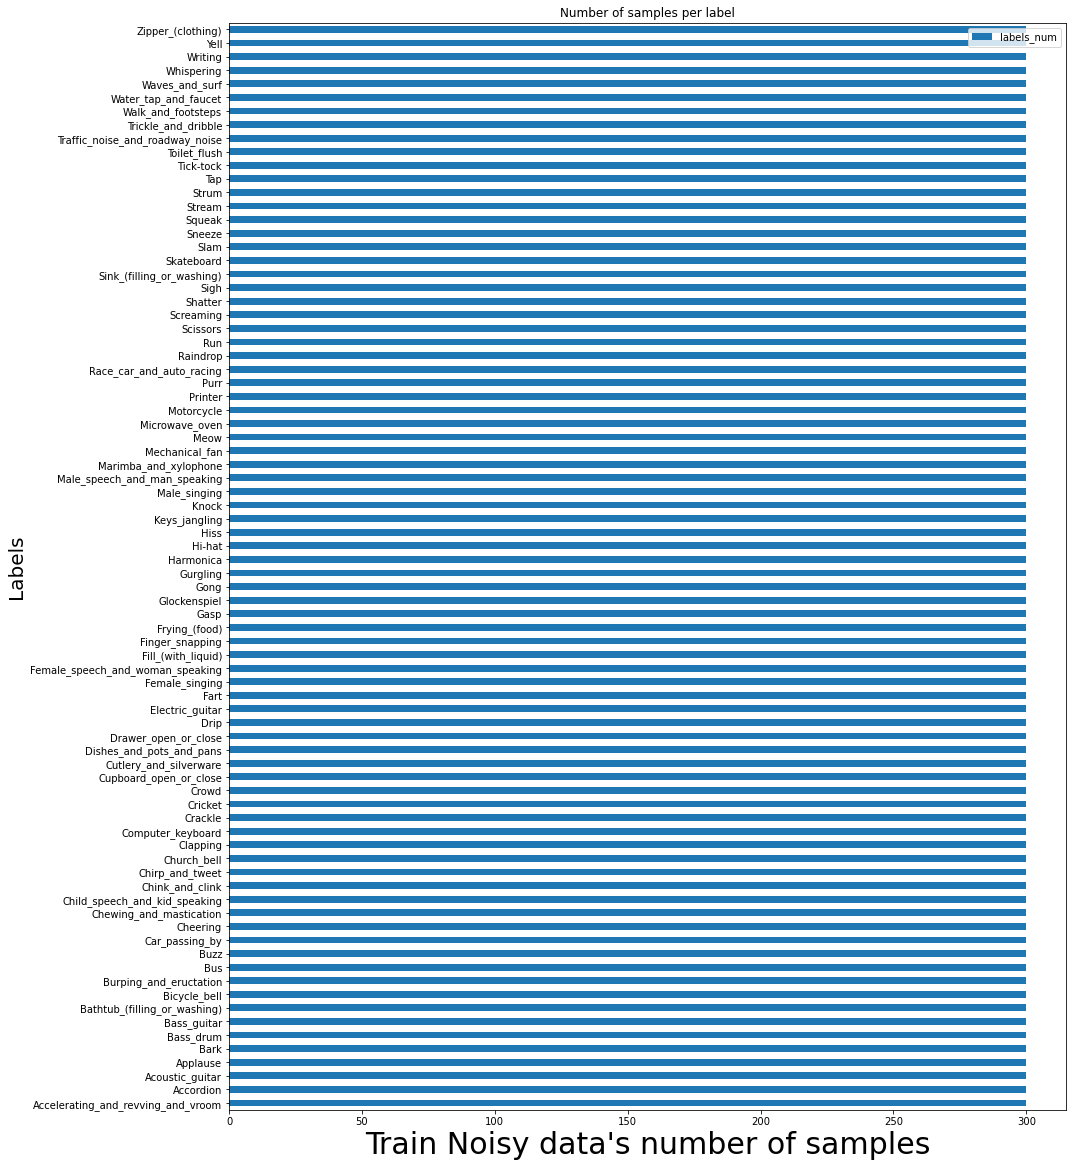

In [33]:
#https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data


noisy_plot_df = pd.DataFrame({"labels_num":list(np.sum(labels_train_noisy, axis=0)),"labels":list(mlb2.classes_)})
noisy_plot_df.set_index('labels',inplace=True)
plot = noisy_plot_df.plot(
    kind='barh',
    title="Number of samples per label",
    figsize=(15,20))
plot.set_xlabel("Train Noisy data's number of samples", fontsize=30)
plot.set_ylabel("Labels", fontsize=20);
